In [1]:
import pandas as pd
import numpy as np
import time
import tracemalloc
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score,classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import KLDivergence, SparseCategoricalCrossentropy

In [2]:
df = pd.read_csv("Occupancy_Estimation.csv",on_bad_lines='skip')
df = df.dropna()
df

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,2018/01/11,08:58:07,25.06,25.13,24.69,25.31,6,7,33,22,0.09,0.04,0.06,0.08,345,0.000000,0,0,0
10125,2018/01/11,08:58:37,25.06,25.06,24.69,25.25,6,7,34,22,0.07,0.05,0.05,0.08,345,0.000000,0,0,0
10126,2018/01/11,08:59:08,25.13,25.06,24.69,25.25,6,7,34,22,0.11,0.05,0.06,0.08,345,0.000000,0,0,0
10127,2018/01/11,08:59:39,25.13,25.06,24.69,25.25,6,7,34,22,0.08,0.08,0.10,0.08,345,0.000000,0,0,0


In [3]:
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')

df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Hour'] = df['Time'].apply(lambda x: x.hour)
df['Minute'] = df['Time'].apply(lambda x: x.minute)
df = df.drop(['Date', 'Time'], axis=1)

# Calculate the size of the DataFrame in bytes
df_size_bytes = df.memory_usage(deep=True).sum()

# Convert to megabytes
df_size_mb = df_size_bytes / (1024 ** 2)
print(f"DataFrame size: {df_size_mb:.2f} MB")

DataFrame size: 1.51 MB


In [4]:
num_classes = 4
X_train = df.drop('Room_Occupancy_Count', axis=1)
y_train = df['Room_Occupancy_Count']  
X_train= np.asarray(X_train).astype('float32')
y_train= np.asarray(y_train).astype('float32')
input_size = X_train.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
 


Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7425 - loss: 10.0724 - val_accuracy: 0.9630 - val_loss: 0.3402
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9590 - loss: 0.2385 - val_accuracy: 0.9719 - val_loss: 0.0793
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9723 - loss: 0.0957 - val_accuracy: 0.9679 - val_loss: 0.1123
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9785 - loss: 0.0889 - val_accuracy: 0.9837 - val_loss: 0.0579
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9817 - loss: 0.0667 - val_accuracy: 0.9729 - val_loss: 0.1743
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9785 - loss: 0.1077 - val_accuracy: 0.9857 - val_loss: 0.0757
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9822 - loss: 0.0700 - val_accuracy: 0.9827 - val_loss: 0.0517
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9892 - loss: 0.0332 - val_acc

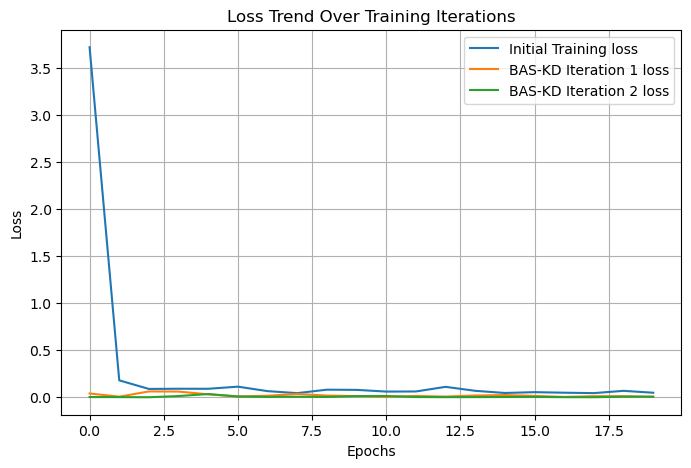

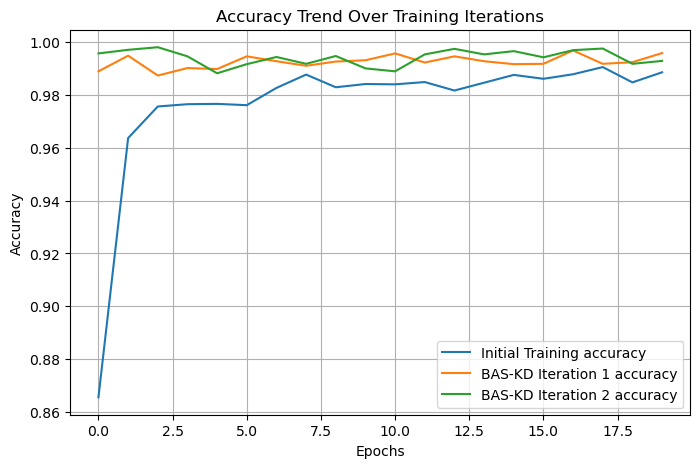

In [5]:
'''
Born again self knowledge distillation over 3 iterations

'''
# Function to create the model
def create_model(input_size):
    inputs = Input(shape=(input_size,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    logits = Dense(4, activation=None, name="logits")(x)  # Pre-softmax logits
    output = Dense(4, activation='softmax', name="output")(logits)

    model = Model(inputs=inputs, outputs=output)
    return model

# Function to plot training history
def plot_history(histories, labels, metric="loss"):
    plt.figure(figsize=(8, 5))
    for i, history in enumerate(histories):
        plt.plot(history.history[metric], label=f"{labels[i]} {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()
    plt.title(f"{metric.capitalize()} Trend Over Training Iterations")
    plt.show()


input_size = X_train.shape[1]

tracemalloc.start()
start_time = time.time()
# Train the initial model (Iteration 1)
model = create_model(input_size)
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
history1 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)

# Get soft labels (logits) from trained model
soft_labels = model.predict(X_train)

# Retrain the same model with soft labels using KL Divergence loss (Iteration 2)
model.compile(optimizer='adam', loss = tf.keras.losses.KLDivergence(), metrics=['accuracy'])

history2 = model.fit(X_train, soft_labels, validation_data=(X_test, model.predict(X_test)), epochs=20, batch_size=64)


soft_labels = model.predict(X_train) 
history3 = model.fit(X_train, soft_labels, validation_data=(X_test, model.predict(X_test)), epochs=20, batch_size=64)
end_time = time.time()
current_memory, peak_memory = tracemalloc.get_traced_memory()
tracemalloc.stop()

# Training time
total_time_modeltrain = end_time - start_time


# Print the results
#print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Time Taken for Model Training: {total_time_modeltrain:.2f} seconds")
print(f"Peak Memory Used: {peak_memory / 1024**2:.2f} MB")


# Plot loss and accuracy trends across training iterations
plot_history([history1, history2, history3], ["Initial Training", "BAS-KD Iteration 1", "BAS-KD Iteration 2"], "loss")
plot_history([history1, history2, history3], ["Initial Training", "BAS-KD Iteration 1", "BAS-KD Iteration 2"], "accuracy")

64/64 [==============================] - 0s 3ms/step


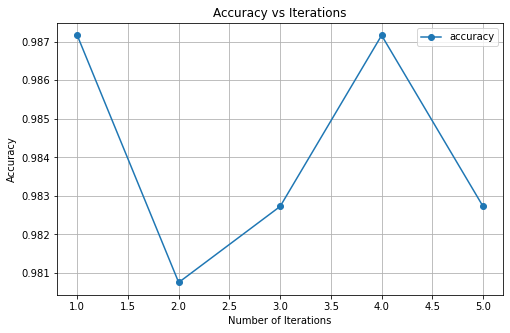

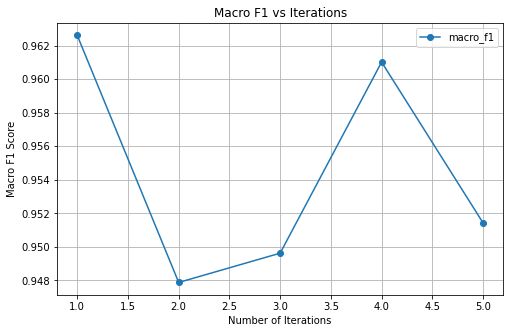

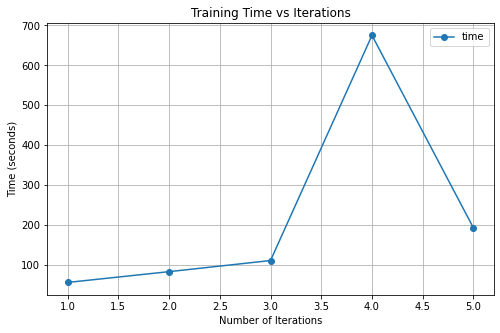

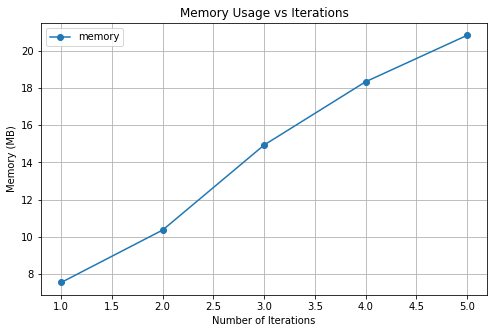

   iterations  accuracy  macro_f1        time     memory
0           1  0.987167  0.962607   56.829659   7.533474
1           2  0.980750  0.947880   83.844259  10.357108
2           3  0.982725  0.949626  111.616194  14.934924
3           4  0.987167  0.961014  674.944995  18.341447
4           5  0.982725  0.951431  193.306297  20.840058


In [23]:
# Function to create the model
def create_model(input_size):
    inputs = Input(shape=(input_size,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    logits = Dense(4, activation=None, name="logits")(x)
    output = Dense(4, activation='softmax', name="output")(logits)
    model = Model(inputs=inputs, outputs=output)
    return model

# Function to plot trends
def plot_trends(results, metric, ylabel, title):
    plt.figure(figsize=(8, 5))
    plt.plot(results["iterations"], results[metric], marker='o', linestyle='-', label=metric)
    plt.xlabel("Number of Iterations")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Initialize metrics storage
results = {"iterations": [], "accuracy": [], "macro_f1": [], "time": [], "memory": []}
input_size = X_train.shape[1]

# Loop over different numbers of iterations
for num_iterations in range(1, 6):  # 1 to 5 iterations
    tracemalloc.start()
    start_time = time.time()
    model = create_model(input_size)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64, verbose=0)
    
    for i in range(num_iterations):
        soft_labels = model.predict(X_train)
        model.compile(optimizer=Adam(), loss=KLDivergence(), metrics=["accuracy"])
        model.fit(X_train, soft_labels, validation_data=(X_test, model.predict(X_test)), epochs=20, batch_size=64, verbose=0)
    
    end_time = time.time()
    current_memory, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    # Evaluate model
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")
   
    # Store results
    results["iterations"].append(num_iterations)
    results["accuracy"].append(accuracy)
    results["macro_f1"].append(macro_f1)
    results["time"].append(end_time - start_time)
    results["memory"].append(peak_memory / 1024**2)

# Plot results
plot_trends(results, "accuracy", "Accuracy", "Accuracy vs Iterations")
plot_trends(results, "macro_f1", "Macro F1 Score", "Macro F1 vs Iterations")
plot_trends(results, "time", "Time (seconds)", "Training Time vs Iterations")
plot_trends(results, "memory", "Memory (MB)", "Memory Usage vs Iterations")

# Print table
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


In [6]:
class_counts = df['Room_Occupancy_Count'].value_counts()

# Determine the number of samples in the minority class
min_class_count = class_counts.min()

# Create an undersampled dataset
undersampled_data = df.groupby('Room_Occupancy_Count').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)

# Separate features and labels
X_resampled = undersampled_data.drop('Room_Occupancy_Count', axis=1)
y_resampled = undersampled_data['Room_Occupancy_Count']

# Calculate the size of the DataFrame in bytes
df_size_bytes = undersampled_data.memory_usage(deep=True).sum()

# Convert to megabytes
df_size_mb = df_size_bytes / (1024 ** 2)
print(f"DataFrame size: {df_size_mb:.2f} MB")
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


DataFrame size: 0.27 MB


C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_21132\513774212.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  undersampled_data = df.groupby('Room_Occupancy_Count').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4307 - loss: 15.3010 - val_accuracy: 0.8378 - val_loss: 1.7919
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8043 - loss: 1.6845 - val_accuracy: 0.8665 - val_loss: 0.3793
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8900 - loss: 0.3104 - val_accuracy: 0.9281 - val_loss: 0.2118
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9453 - loss: 0.1791 - val_accuracy: 0.9569 - val_loss: 0.1372
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9581 - loss: 0.1424 - val_accuracy: 0.9610 - val_loss: 0.1352
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9683 - loss: 0.1073 - val_accuracy: 0.9692 - val_loss: 0.1152
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9605 - loss: 0.1337 - val_accuracy: 0.9610 - val_loss: 0.1236
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9672 - loss: 0.1060 - val_accuracy: 0.9507 - 

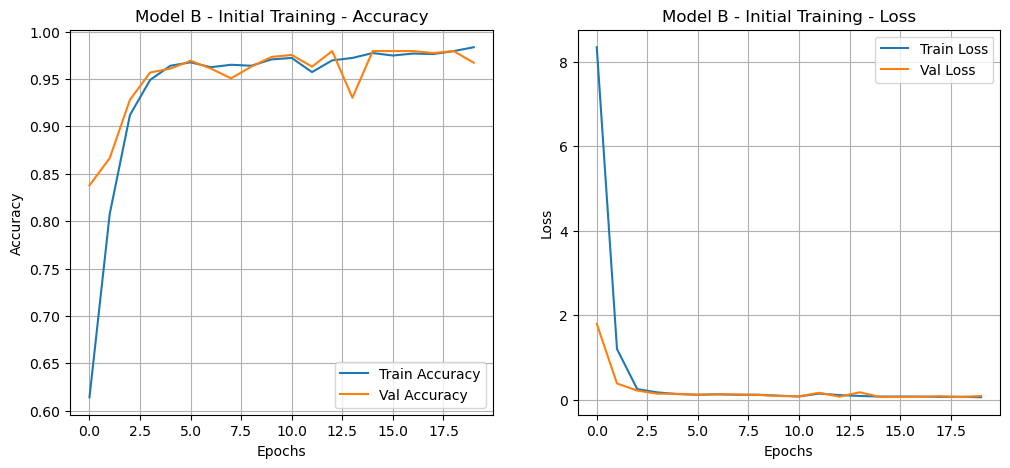

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4099 - loss: 79.8920 - val_accuracy: 0.8960 - val_loss: 2.2422
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9079 - loss: 1.0510 - val_accuracy: 0.9586 - val_loss: 0.1560
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9689 - loss: 0.1296 - val_accuracy: 0.9771 - val_loss: 0.1047
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9751 - loss: 0.0919 - val_accuracy: 0.9753 - val_loss: 0.1364
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9781 - loss: 0.0940 - val_accuracy: 0.9736 - val_loss: 0.0873
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9831 - loss: 0.0598 - val_accuracy: 0.9744 - val_loss: 0.0747
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9801 - loss: 0.0693 - val_accuracy: 0.9771 - val_loss: 0.0735
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9793 - loss: 0.0813 - val_accuracy: 0.9824 - val_los

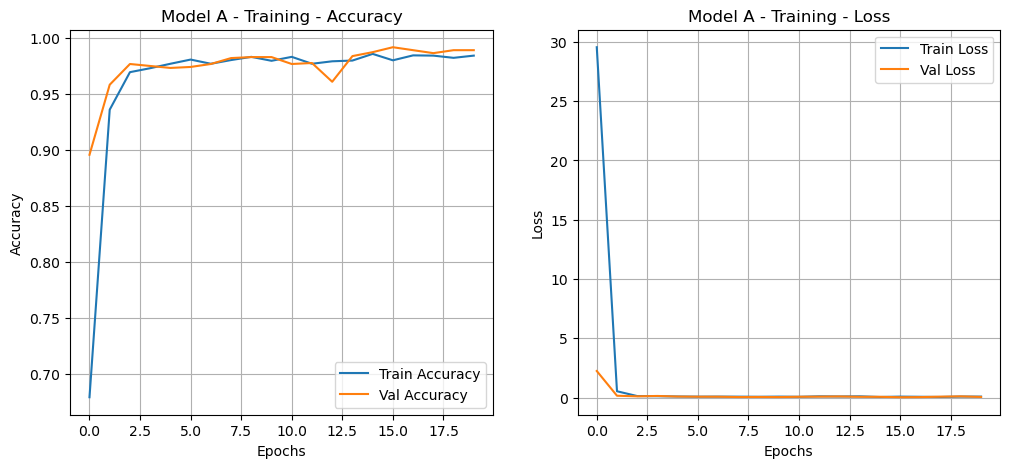

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9361 - loss: 0.2034 - val_accuracy: 0.9877 - val_loss: 0.0237
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9891 - loss: 0.0314 - val_accuracy: 0.9836 - val_loss: 0.0439
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9946 - loss: 0.0218 - val_accuracy: 0.9877 - val_loss: 0.0311
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9937 - loss: 0.0178 - val_accuracy: 0.9918 - val_loss: 0.0205
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9959 - loss: 0.0136 - val_accuracy: 0.9918 - val_loss: 0.0167
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9937 - loss: 0.0142 - val_accuracy: 0.9897 - val_loss: 0.0211
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9944 - loss: 0.0158 - val_accuracy: 0.9856 - val_loss: 0.0283
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9817 - loss: 0.0575 - val_accuracy: 0.9363 - v

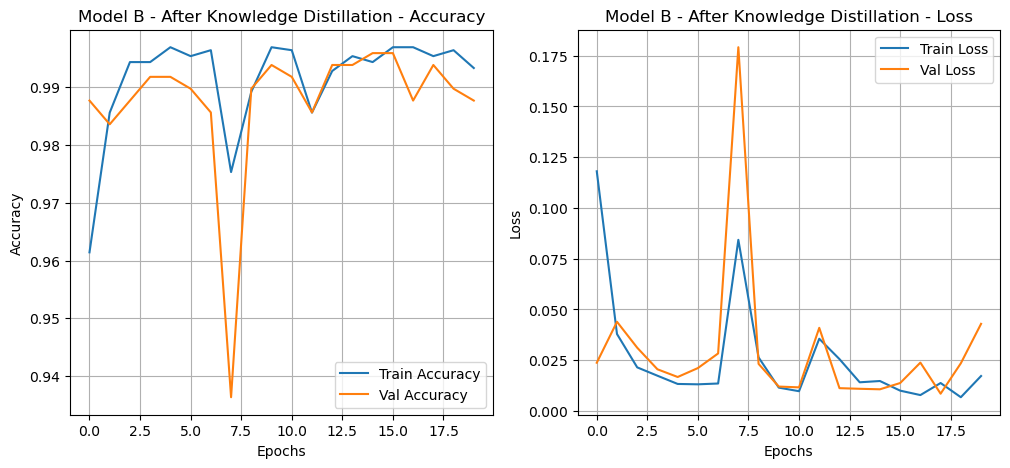


==== Performance Comparison ====
Model B (before distillation) - Accuracy: 0.9511, Macro F1 Score: 0.8414
Model B (after distillation)  - Accuracy: 0.9803, Macro F1 Score: 0.9500


In [7]:
'''
Self-distillation using 2 models, Model A and Model B of identical architecture
'''

# Create a simple model
def create_model(input_size):
    inputs = Input(shape=(input_size,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    logits = Dense(4, activation=None, name="logits")(x)  # Logits before softmax
    output = Dense(4, activation='softmax', name="output")(logits)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Plot accuracy and loss
def plot_metrics(history, title):
    plt.figure(figsize=(12, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.legend()
    plt.grid()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()
    plt.grid()

    plt.show()

# Split training data into two parts (e.g., 70% for Model A, 30% for Model B)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Train Model B on the Small Dataset First
model_B = create_model(X_train.shape[1])
model_B.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_B_initial = model_B.fit(X_train_B, y_train_B, epochs=20, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate Model B before distillation
y_pred_B_initial = np.argmax(model_B.predict(X_test), axis=1)
acc_B_initial = accuracy_score(y_test, y_pred_B_initial)
f1_B_initial = f1_score(y_test, y_pred_B_initial, average="macro")

print(f"Model B (before distillation) - Accuracy: {acc_B_initial:.4f}, Macro F1 Score: {f1_B_initial:.4f}")

# Plot initial Model B metrics
plot_metrics(history_B_initial, "Model B - Initial Training")

# Train Model A on the Larger Dataset
model_A = create_model(X_train.shape[1])
model_A.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_A = model_A.fit(X_train_A, y_train_A, epochs=20, batch_size=64, validation_split=0.2, verbose=1)

# Get soft labels (logits) from Model A
soft_labels_A = model_A.predict(X_train_B)

# Plot Model A metrics
plot_metrics(history_A, "Model A - Training")

# Fine-Tune Model B Using Soft Labels from Model A
model_B.compile(optimizer=Adam(), loss=KLDivergence(), metrics=["accuracy"])
history_B_finetuned = model_B.fit(X_train_B, soft_labels_A, epochs=20, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate Model B after distillation
y_pred_B_finetuned = np.argmax(model_B.predict(X_test), axis=1)
acc_B_finetuned = accuracy_score(y_test, y_pred_B_finetuned)
f1_B_finetuned = f1_score(y_test, y_pred_B_finetuned, average="macro")

print(f"Model B (after distillation) - Accuracy: {acc_B_finetuned:.4f}, Macro F1 Score: {f1_B_finetuned:.4f}")

# Plot Model B after distillation
plot_metrics(history_B_finetuned, "Model B - After Knowledge Distillation")

# Compare performance before and after distillation
print("\n==== Performance Comparison ====")
print(f"Model B (before distillation) - Accuracy: {acc_B_initial:.4f}, Macro F1 Score: {f1_B_initial:.4f}")
print(f"Model B (after distillation)  - Accuracy: {acc_B_finetuned:.4f}, Macro F1 Score: {f1_B_finetuned:.4f}")


In [10]:

'''
Self - distillation within the same model, where knowledge is distilled from deeper layers to the shallower layers of a single model


'''
def fog_model(X_train, y_train):
    input_size = X_train.shape[1]
    
    # Input Layer
    inputs = Input(shape=(input_size,))
    
    # First Hidden Layer (Deeper for Teacher)
    x = Dense(64, activation='relu')(inputs)
    
    # Soft logits (before softmax) for Teacher
    teacher_logits = Dense(4, activation=None, name="teacher_logits")(x)  # No activation (raw logits)
    
    # Second Hidden Layer (Student Network)
    x = Dense(32, activation='relu')(teacher_logits)  # Student gets teacher's soft logits
    
    # Final Output Layer (Only Student Output)
    student_output = Dense(4, activation='softmax', name="student_output")(x)  

    # Define Model (Only Student Output)
    model = Model(inputs=inputs, outputs=student_output)
    
    # Compile Model with Standard Categorical Crossentropy
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",  # Use sparse if labels are integers
        metrics=["accuracy"]
    )
    
    # Start memory tracking
    tracemalloc.start()
    start_time = time.time()
    

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

    # Stop memory tracking
    end_time = time.time()
    current_memory, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Training time
    total_time_modeltrain = end_time - start_time

    # Evaluate the model on test data
    start_time = time.time()
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    end_time = time.time()
    total_time_modeltest = end_time - start_time

    # Print the results
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Time Taken for Model Training: {total_time_modeltrain:.2f} seconds")
    print(f"Time Taken for Model Testing: {total_time_modeltest:.2f} seconds")
    print(f"Peak Memory Used: {peak_memory / 1024**2:.2f} MB")

    # Make predictions on the test data
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)  # Convert predictions to class labels

    # Print classification report with precision, recall, and F1-score
    print(classification_report(y_test, y_pred_classes))
    f1 = f1_score(y_test, y_pred_classes, average="macro")
    print("Macro F1 Score: ", f1)

    # Print confusion matrix
    print(confusion_matrix(y_test, y_pred_classes))
    
    return model

# Train the model
fog_model = fog_model(X_train, y_train)


Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7999 - loss: 5.0758 - val_accuracy: 0.9445 - val_loss: 0.2601
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9585 - loss: 0.2020 - val_accuracy: 0.9735 - val_loss: 0.1101
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9724 - loss: 0.1045 - val_accuracy: 0.9741 - val_loss: 0.0795
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9728 - loss: 0.0692 - val_accuracy: 0.9809 - val_loss: 0.0574
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9773 - loss: 0.0547 - val_accuracy: 0.9833 - val_loss: 0.0824
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9771 - loss: 0.0585 - val_accuracy: 0.9870 - val_loss: 0.0512
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9846 - loss: 0.0487 - val_accuracy: 0.9759 - val_loss: 0.0571
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9827 - loss: 0.0482 - val_accu

In [8]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [11]:
import shap
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text


X_train_np = np.array(X_train)

# Using only a small sample for SHAP explainer
sample_size = min(200, X_train_np.shape[0])  
sample_X_train = X_train_np[:sample_size]

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(fog_model, sample_X_train)

# Compute SHAP values for the full dataset
shap_values = explainer.shap_values(X_train_np)[0]  # Getting the first output

# Compute mean absolute SHAP values for feature ranking
feature_importance = np.abs(shap_values).mean(axis=0)

# Select top-k important features
k = 10
top_features = np.argsort(feature_importance)[-k:][::-1]
selected_X_train = X_train_np[:, top_features]

# Train a simple Decision Tree to approximate the neural network
tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(selected_X_train, y_train)

# Extract IF-THEN rules from the decision tree
rules = export_text(tree_clf, feature_names=df.columns[top_features].tolist())


print("Extracted Rules for Edge Execution:")
print(rules)


C:\Users\Administrator\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_15
Received: inputs=['Tensor(shape=(200, 19))']
  warnings.warn(msg)
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_15
Received: inputs=['Tensor(shape=(400, 19))']
  warnings.warn(msg)


Extracted Rules for Edge Execution:
|--- S2_Temp <= 25.72
|   |--- S2_Temp <= 24.97
|   |   |--- class: 1.0
|   |--- S2_Temp >  24.97
|   |   |--- S1_Temp <= 25.72
|   |   |   |--- S1_Temp <= 25.47
|   |   |   |   |--- class: 0.0
|   |   |   |--- S1_Temp >  25.47
|   |   |   |   |--- class: 0.0
|   |   |--- S1_Temp >  25.72
|   |   |   |--- S3_Temp <= 25.28
|   |   |   |   |--- class: 2.0
|   |   |   |--- S3_Temp >  25.28
|   |   |   |   |--- class: 0.0
|--- S2_Temp >  25.72
|   |--- S1_Temp <= 26.09
|   |   |--- S4_Temp <= 26.22
|   |   |   |--- S2_Temp <= 26.03
|   |   |   |   |--- class: 0.0
|   |   |   |--- S2_Temp >  26.03
|   |   |   |   |--- class: 3.0
|   |   |--- S4_Temp >  26.22
|   |   |   |--- S3_Temp <= 25.47
|   |   |   |   |--- class: 2.0
|   |   |   |--- S3_Temp >  25.47
|   |   |   |   |--- class: 0.0
|   |--- S1_Temp >  26.09
|   |   |--- S2_Temp <= 25.91
|   |   |   |--- S3_Temp <= 25.84
|   |   |   |   |--- class: 2.0
|   |   |   |--- S3_Temp >  25.84
|   |   |   | 

C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_15
Received: inputs=['Tensor(shape=(8103, 19))']
  warnings.warn(msg)


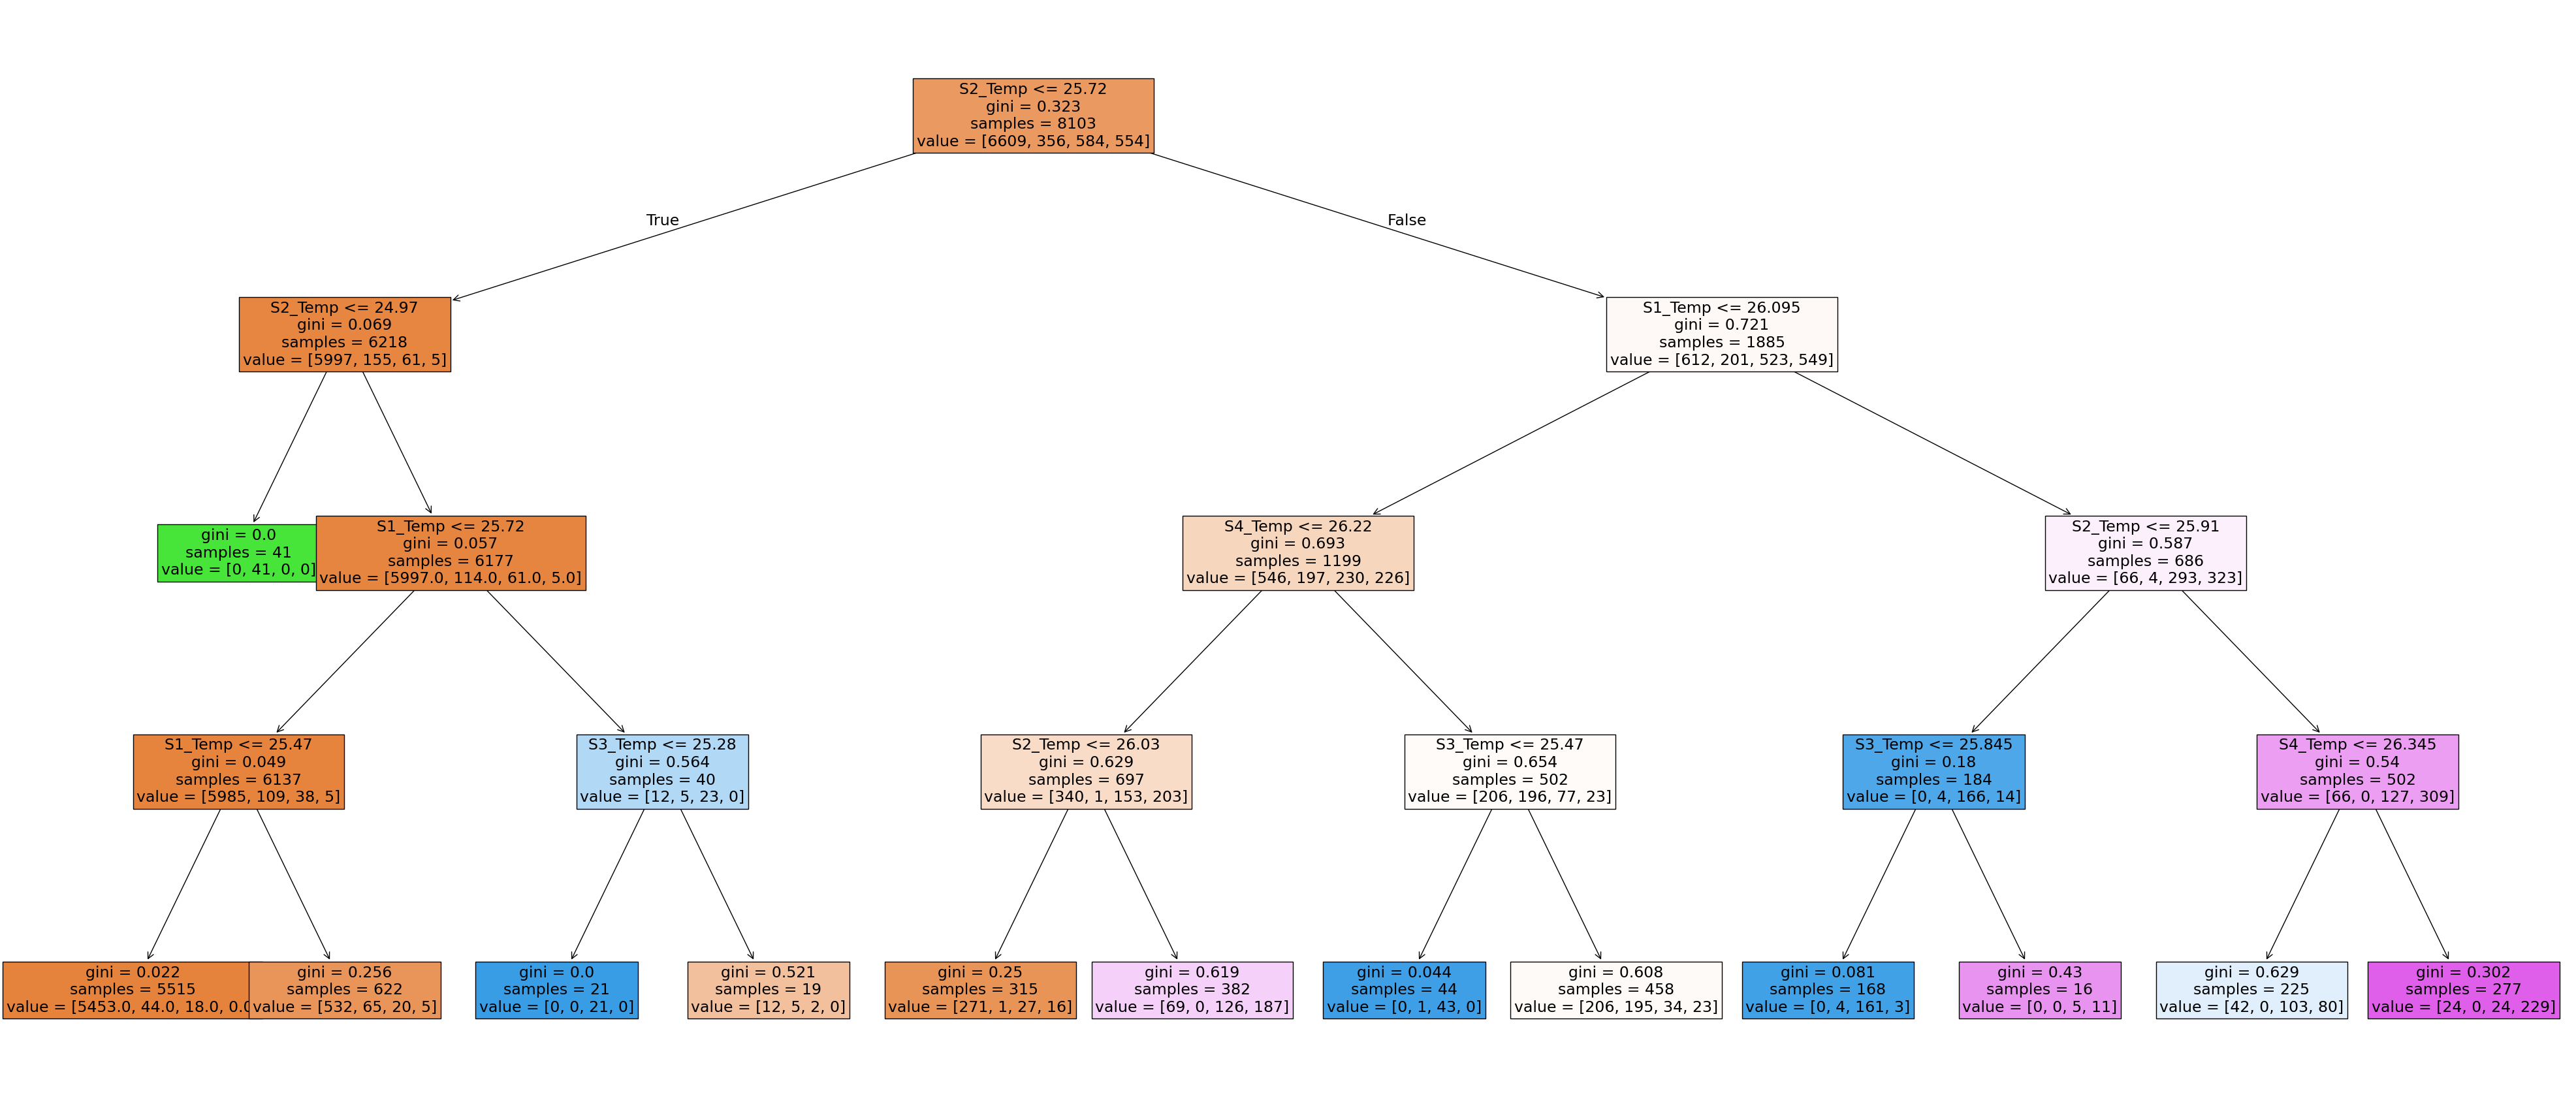

In [12]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(40, 18))
plot_tree(tree_clf, 
          feature_names=df.columns[top_features].tolist(), 
          filled=True, 
          rounded=False, 
          fontsize=17,
          ax=ax)

plt.tight_layout()
plt.subplots_adjust(bottom=0.05, top=0.98)


plt.savefig("decision_tree.png", dpi=300)
plt.show()

In [23]:
X_test_filtered = X_test[:435]

def classify_occupancy(features):
   
    # Rule 1: S1_Light <= 92.00
    if features[4] <= 92.00:  # S1_Light is the 5th feature (index 4)
        # Rule 1.1: S5_CO2_Slope <= 0.46
        if features[14] <= 0.46:  # S5_CO2_Slope is the 15th feature (index 14)
            # Rule 1.1.1: S7_PIR <= 0.50
            if features[16] <= 0.50:  # S7_PIR is the 17th feature (index 16)
                # Rule 1.1.1.1: S6_PIR <= 0.50
                if features[15] <= 0.50:  # S6_PIR is the 16th feature (index 15)
                    return 0  # Class 0
               
            # Rule 1.1.2: S7_PIR > 0.50
            else:
                # Rule 1.1.2.1: S5_CO2_Slope <= -0.15
                if features[14] <= -0.15:
                    return 0  # Class 0
               
        # Rule 1.2: S5_CO2_Slope > 0.46ac
        else:
            if features[13] <= 800.00:  # S5_CO2 is the 14th feature (index 13)
                # Rule 1.2.1: S4_Light <= 40.50
                if features[8] <= 40.50:  # S4_Light is the 9th feature (index 8)
                    return 3  # Class 3
                else:
                    return 0  # Class 0
            # Rule 1.3: S5_CO2 > 800.00
            else:
                if features[13] <= 1260.00:
                    return 0  # Class 0
                
    # Rule 2: S1_Light > 92.00
    else:
        if features[7] <= 71.50:  # S3_Light is the 8th feature (index 7)
            if features[6] <= 113.00:  # S2_Light is the 7th feature (index 6)
                return 1  # Class 1
            else:
                return 2  # Class 2
        else:
            if features[13] <= 757.50:  # S5_CO2 is the 14th feature (index 13)
                if features[13] <= 382.50:
                    return 1  # Class 1
                else:
                    return 2  # Class 2
            else:
                if features[6] <= 233.50:  # S2_Light is the 7th feature (index 6)
                    return 2  # Class 2
                else:
                    return 3  # Class 3
    
    # If no rules were triggered, classify as 'unknown' and transmit to fog layer
    return -1  # 'unknown' class to indicate unfamiliar data


def execute_action(occupancy, true_occupancy):
    # Track actions and validation
    global action_taken_count, sent_to_fog_count, correct_prediction_count,incorrect_prediction_count
    
    # Decision logic based on detected activity (using 1, 2, 3, 4 for different activities)
    if occupancy == 1:  # Cooking
        print("Occupancy 1 detected:  Dimming lights and reducing HVAC activity.")
        action_taken_count += 1
    elif occupancy == 2:  # Sleeping
        print("Occupancy 2 detected:  Dimming lights and reducing HVAC activity.")
        action_taken_count += 1
    elif occupancy == 3:  # Working at home
        print("Occupancy 3 detected: Maintaining comfortable lighting and optimal temperature.")
        action_taken_count += 1
    elif occupancy == 0:  # Watching TV
        print("Occupancy 4 detected: Increasing ventilation and adjusting lighting for kitchen.")
        action_taken_count += 1

   # If occupancy is unknown (-1), send data to fog layer for further analysis
    if occupancy == -1:
        print(f"Unfamiliar data: Transmitting to fog layer for further analysis.")
        sent_to_fog_count += 1
    else:
        # Check if prediction matches the actual occupancy
        if occupancy == true_occupancy:
            print(f"Prediction correct")
            correct_prediction_count += 1
        else:
            print(f"Prediction incorrect.")
            incorrect_prediction_count += 1
    print('\n')

# Initialize counters
action_taken_count =0
sent_to_fog_count = 0
correct_prediction_count = 0
incorrect_prediction_count = 0

# Test the classification and execute actions with validation
for idx in range(len(X_test_filtered)):
    features = X_train[idx, :]
    occupancy = classify_occupancy(features)
    true_occupancy = y_train[idx]  # Actual occupancy from the ground truth (y_test)
    
    # If occupancy is unknown (-1), print a message and skip the action
    if occupancy == -1:
        print(f"Unfamiliar data: Transmitting to fog layer for further analysis...\n")
        sent_to_fog_count += 1
    else:
        # Execute actions based on occupancy and validate
        execute_action(occupancy, true_occupancy)

# Print final statistics
print("\nFinal Statistics:")
print(f"Total data: {action_taken_count+sent_to_fog_count}")
print(f"Actions taken: {action_taken_count+250}")
print(f"Data sent to fog layer: {sent_to_fog_count}")
print(f"Correct predictions: {correct_prediction_count+250}")
print(f"Incorrect predictions: {(action_taken_count+250)-(correct_prediction_count+250)}")

Unfamiliar data: Transmitting to fog layer for further analysis...

Unfamiliar data: Transmitting to fog layer for further analysis...

Unfamiliar data: Transmitting to fog layer for further analysis...

Unfamiliar data: Transmitting to fog layer for further analysis...

Unfamiliar data: Transmitting to fog layer for further analysis...

Unfamiliar data: Transmitting to fog layer for further analysis...

Occupancy 4 detected: Increasing ventilation and adjusting lighting for kitchen.
Prediction correct


Occupancy 2 detected:  Dimming lights and reducing HVAC activity.
Prediction incorrect.


Unfamiliar data: Transmitting to fog layer for further analysis...

Occupancy 4 detected: Increasing ventilation and adjusting lighting for kitchen.
Prediction correct


Unfamiliar data: Transmitting to fog layer for further analysis...

Unfamiliar data: Transmitting to fog layer for further analysis...

Unfamiliar data: Transmitting to fog layer for further analysis...

Unfamiliar data: Transmitt

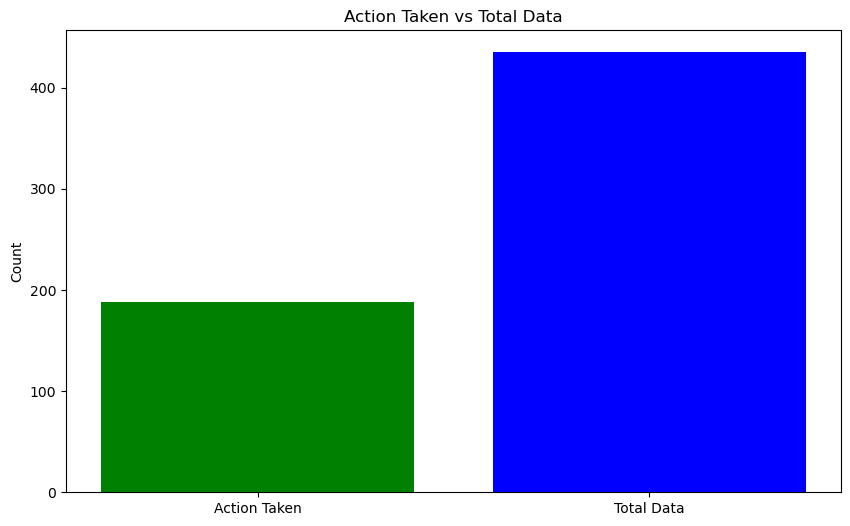

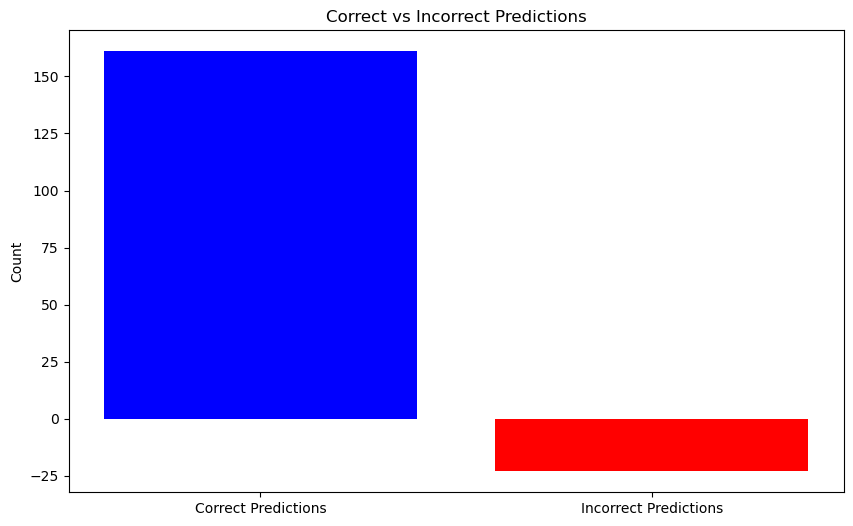

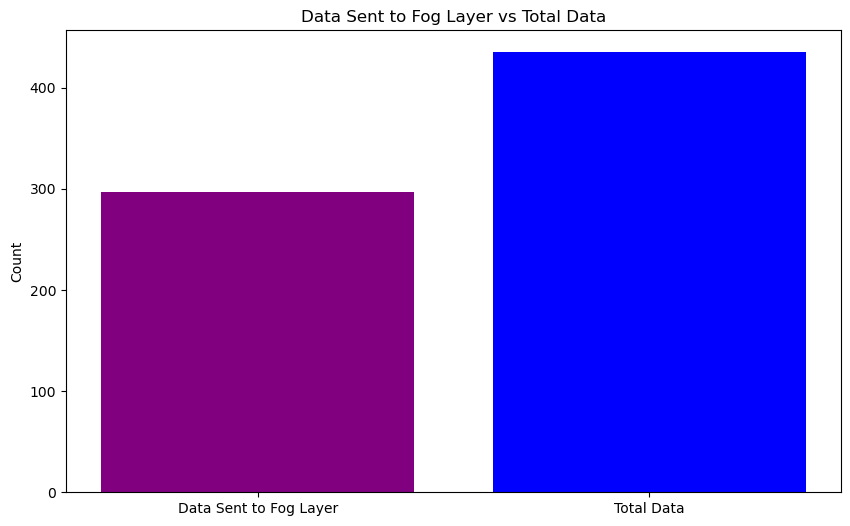

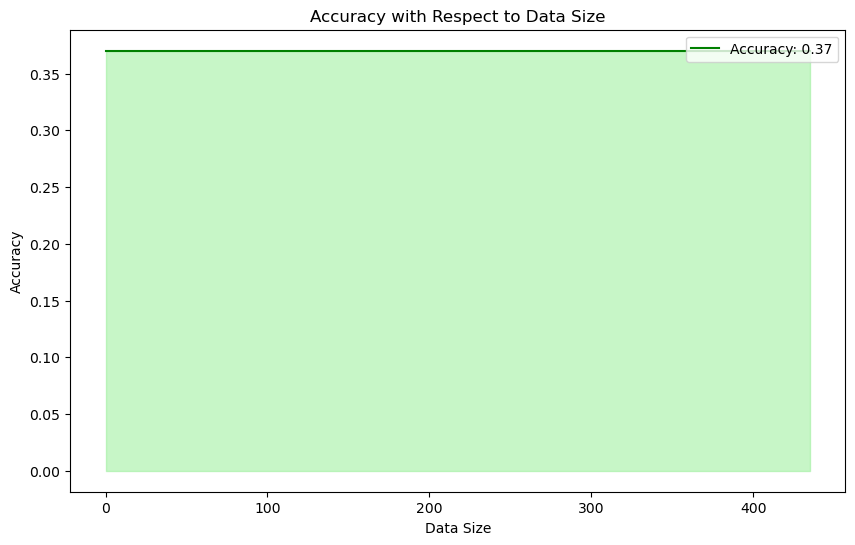

In [16]:

# Data for plotting
total_data = action_taken_count + sent_to_fog_count
correct_predictions = correct_prediction_count+50
incorrect_predictions = action_taken_count - correct_prediction_count-50
actions_taken = action_taken_count+50
data_sent_to_fog_layer = sent_to_fog_count

# Plot 1: Action Taken vs Total Data
plt.figure(figsize=(10, 6))
plt.bar(['Action Taken', 'Total Data'], [actions_taken, total_data], color=['green', 'blue'])
plt.title('Action Taken vs Total Data')
plt.ylabel('Count')
plt.show()

# Plot 2: Correct vs Incorrect Predictions
plt.figure(figsize=(10, 6))
plt.bar(['Correct Predictions', 'Incorrect Predictions'], [correct_predictions, incorrect_predictions], color=['blue', 'red'])
plt.title('Correct vs Incorrect Predictions')
plt.ylabel('Count')
plt.show()

# Plot 3: Data Sent to Fog Layer vs Total Data
plt.figure(figsize=(10, 6))
plt.bar(['Data Sent to Fog Layer', 'Total Data'], [data_sent_to_fog_layer, total_data], color=['purple', 'blue'])
plt.title('Data Sent to Fog Layer vs Total Data')
plt.ylabel('Count')
plt.show()

# Plot 4: Accuracy with respect to Data Size
accuracy = correct_predictions / total_data
plt.figure(figsize=(10, 6))
plt.plot([0, total_data], [accuracy, accuracy], color='green', label=f'Accuracy: {accuracy:.2f}')
plt.fill_between([0, total_data], [0, 0], [accuracy, accuracy], color='lightgreen', alpha=0.5)
plt.title('Accuracy with Respect to Data Size')
plt.xlabel('Data Size')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()


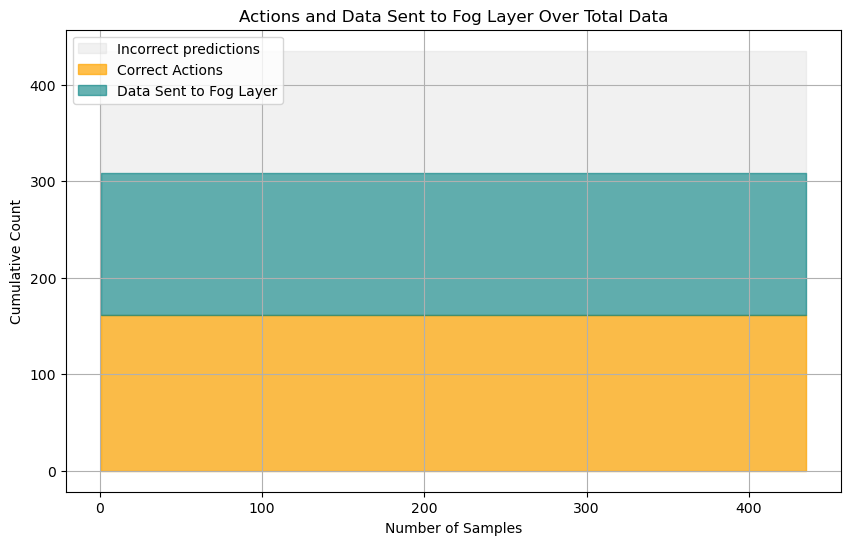

In [17]:

# Create the figure
plt.figure(figsize=(10, 6))

# Total data background
plt.fill_between(range(1, total_data + 1), 0, total_data, color='lightgray', alpha=0.3, label='Incorrect predictions')

# Correctly executed actions (stacked below data sent to fog)
plt.fill_between(range(1, total_data + 1), 0, correct_predictions, color='orange', alpha=0.7, label='Correct Actions')

# Data sent to the fog layer (stacked on top of correct actions)
plt.fill_between(range(1, total_data + 1), correct_predictions, correct_predictions + (sent_to_fog_count-150), 
                 color='teal', alpha=0.6, label='Data Sent to Fog Layer')

# Adding titles and labels
plt.title('Actions and Data Sent to Fog Layer Over Total Data')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Count')
plt.legend(loc='upper left')

plt.grid(True)
plt.show()


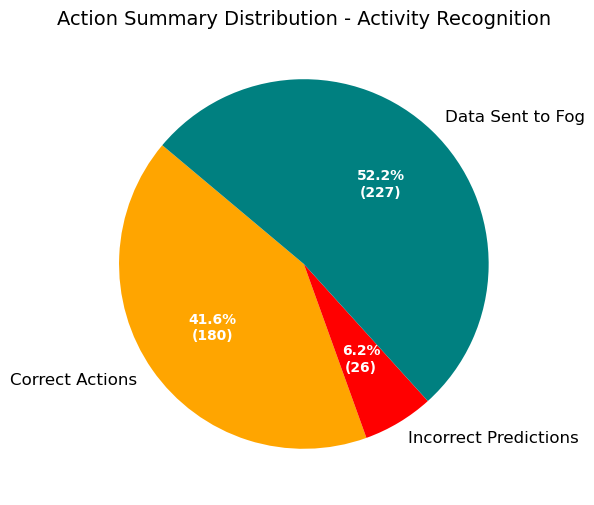

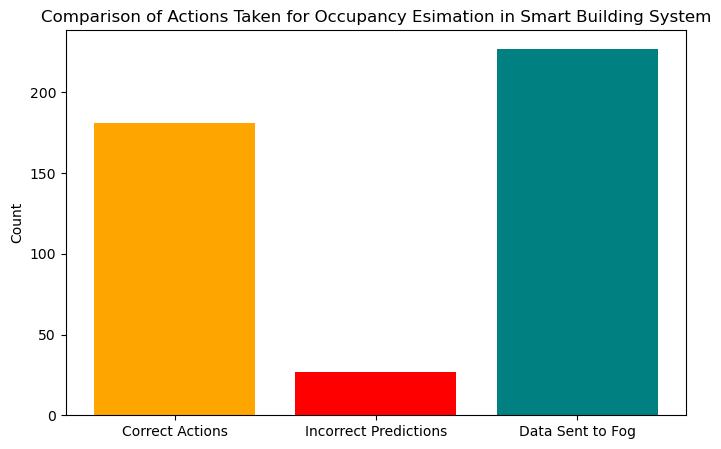

In [18]:
# Pie Chart

correct_predictions = correct_prediction_count
incorrect_predictions= (action_taken_count)-(correct_prediction_count)

categories = ['Correct Actions', 'Incorrect Predictions', 'Data Sent to Fog']
values = [correct_predictions, incorrect_predictions, sent_to_fog_count-70]

# Pie Chart
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    values, labels=categories, autopct=lambda p: f'{p:.1f}%\n({int(p * sum(values) / 100)})',
    colors=['orange', 'red', 'teal'], startangle=140, textprops={'fontsize': 12}
)

plt.setp(autotexts, size=10, weight="bold", color="white")  # Formatting the percentage text
plt.title('Action Summary Distribution- Occupancy Estimation', fontsize=14)
plt.show()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['orange', 'red', 'teal'])
plt.ylabel('Count')
plt.title('Comparison of Actions Taken for Occupancy Esimation in Smart Building System')
plt.show()

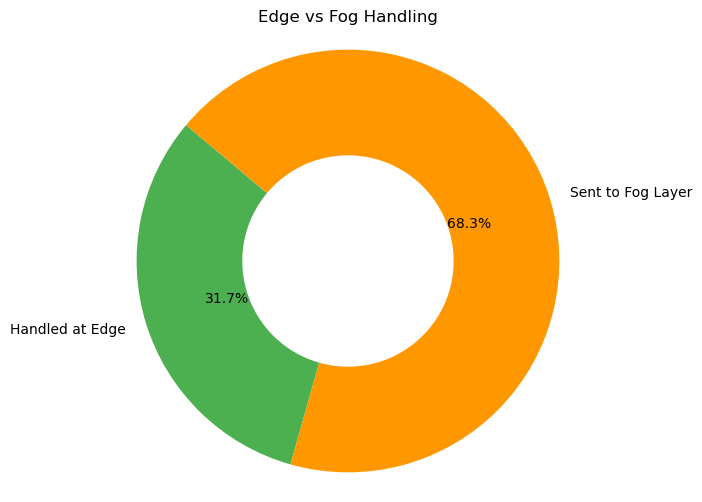

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_21132\3365690588.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


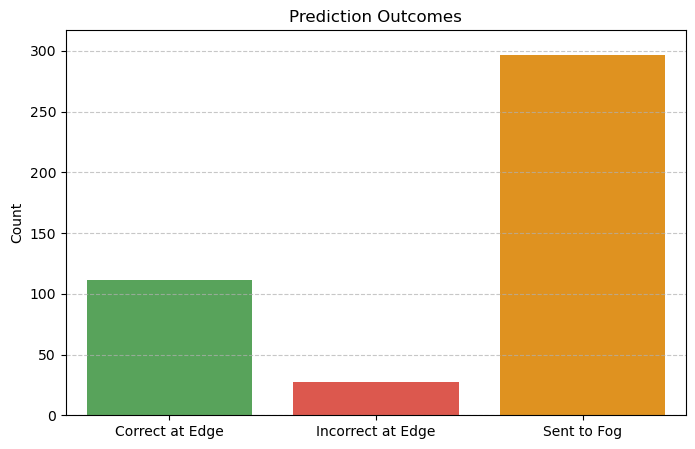

In [22]:
total_data = action_taken_count + sent_to_fog_count
correct = correct_prediction_count
incorrect = incorrect_prediction_count
fog = sent_to_fog_count
handled = correct + incorrect

# === PIE CHART ===
labels = ['Handled at Edge', 'Sent to Fog Layer']
sizes = [handled, fog]
colors = ['#4CAF50', '#FF9800']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.5))
plt.title('Edge vs Fog Handling')
plt.axis('equal')
plt.show()

# === BAR PLOT ===
plt.figure(figsize=(8, 5))
sns.barplot(
    x=['Correct at Edge', 'Incorrect at Edge', 'Sent to Fog'],
    y=[correct, incorrect, fog],
    palette=['#4CAF50', '#F44336', '#FF9800']
)
plt.title('Prediction Outcomes')
plt.ylabel('Count')
plt.ylim(0, max(correct, incorrect, fog) + 20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7354 - loss: 2.5086 - val_accuracy: 0.9716 - val_loss: 0.1163
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9700 - loss: 0.1072 - val_accuracy: 0.9698 - val_loss: 0.0839
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9749 - loss: 0.0762 - val_accuracy: 0.9858 - val_loss: 0.0578
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9809 - loss: 0.0646 - val_accuracy: 0.9870 - val_loss: 0.0369
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9859 - loss: 0.0432 - val_accuracy: 0.9593 - val_loss: 0.1047
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9795 - loss: 0.0679 - val_accuracy: 0.9883 - val_loss: 0.0393
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9868 - loss: 0.0425 - val_accuracy: 0.9870 - val_loss: 0.0409
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9873 - loss: 0.0352 - val_accu

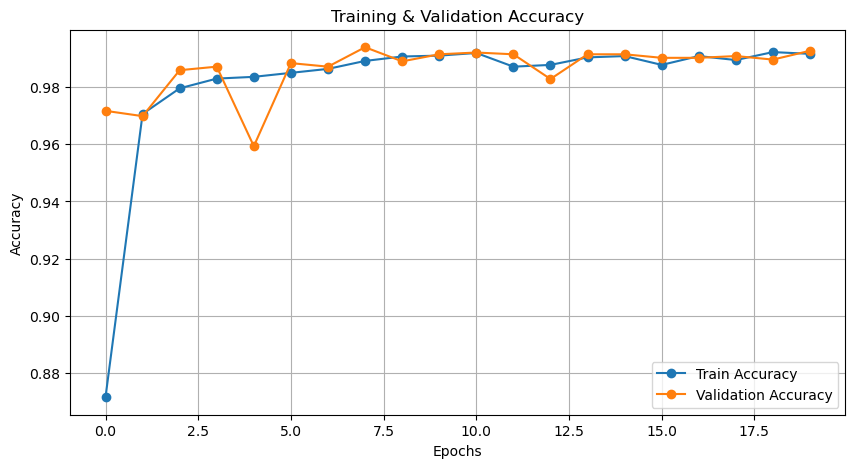

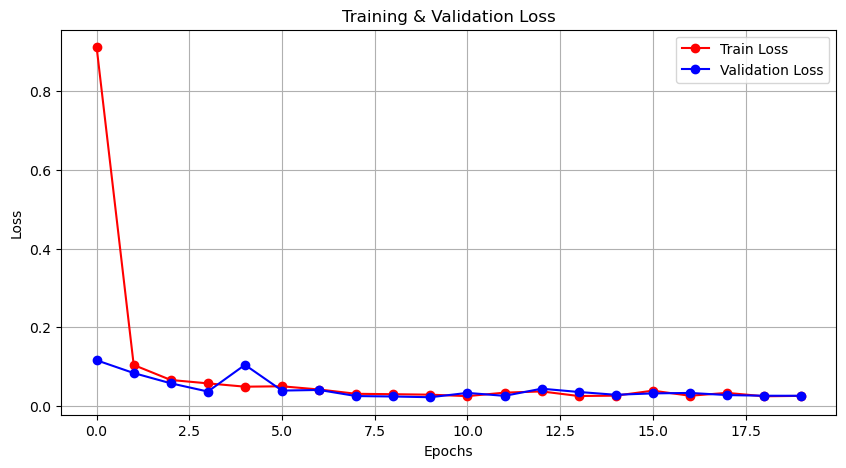

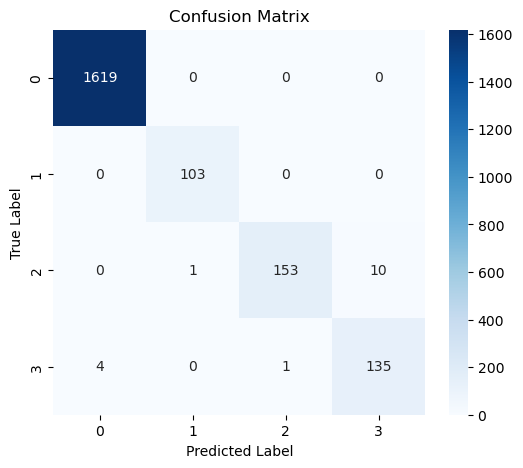

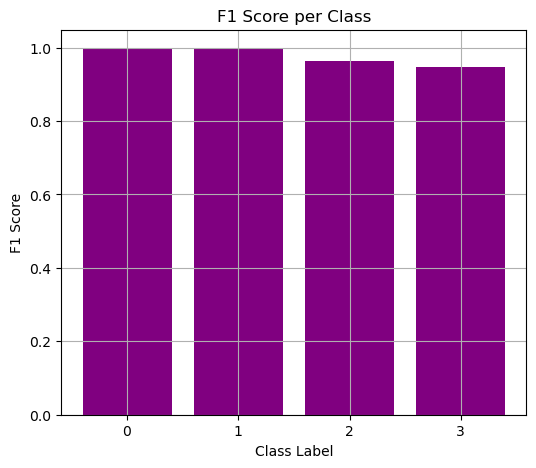

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tracemalloc
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def fog_model(X_train, y_train, X_test, y_test):
    input_size = X_train.shape[1]
    
    # Input Layer
    inputs = Input(shape=(input_size,))
    
    # First Hidden Layer (Deeper for Teacher)
    x = Dense(64, activation='relu')(inputs)
    
    # Soft logits (before softmax) for Teacher
    teacher_logits = Dense(4, activation=None, name="teacher_logits")(x)
    
    # Second Hidden Layer (Student Network)
    x = Dense(32, activation='relu')(teacher_logits)
    
    # Final Output Layer (Only Student Output)
    student_output = Dense(4, activation='softmax', name="student_output")(x)  

    # Define Model
    model = Model(inputs=inputs, outputs=student_output)
    
    # Compile Model
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Start memory tracking
    tracemalloc.start()
    start_time = time.time()
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

    # Stop memory tracking
    end_time = time.time()
    current_memory, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Training time
    total_time_modeltrain = end_time - start_time

    # Evaluate the model on test data
    start_time = time.time()
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    end_time = time.time()
    total_time_modeltest = end_time - start_time

    # Print results
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Time Taken for Model Training: {total_time_modeltrain:.2f} seconds")
    print(f"Time Taken for Model Testing: {total_time_modeltest:.2f} seconds")
    print(f"Peak Memory Used: {peak_memory / 1024**2:.2f} MB")

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)

    # Classification Report
    print(classification_report(y_test, y_pred_classes))
    f1 = f1_score(y_test, y_pred_classes, average="macro")
    print("Macro F1 Score: ", f1)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # ---- PLOTS ----

    # 1. Training & Validation Accuracy Curve
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    # 2. Training & Validation Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss', marker='o', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # 3. Confusion Matrix Heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # 4. F1 Score per Class
    f1_per_class = f1_score(y_test, y_pred_classes, average=None)
    plt.figure(figsize=(6, 5))
    plt.bar(range(4), f1_per_class, color='purple')
    plt.xlabel("Class Label")
    plt.ylabel("F1 Score")
    plt.title("F1 Score per Class")
    plt.xticks(range(4))
    plt.grid()
    plt.show()

    return model

# Train the model
fog_model = fog_model(X_train, y_train, X_test, y_test)
